- Co łączy kluby wykonujące najwięcej transferów?
- Czy najczęśniej dokonujące transferów kluby jednorazowo wymieniają dużą część składu, czy dzieje się to co rok?
- Który z klubów pełnił kluczową rolę w przepływie transferów między klubami?
- Kluby mające największy wpływ na wychowanie piłkarzy?
- W których krajach utworzyły się grupy klubów najczęściej wymieniających się piłkarzami?

In [45]:
from contextlib import contextmanager
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

@contextmanager
def unlimited_data_card():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)

    yield None

    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [46]:
FIFA_PLAYERS_DATA = list((Path.cwd() / "fifa_players_data").glob("*"))
TOP_DISPLAY = 20

In [47]:
FIFA_PLAYERS_DATA

[PosixPath('/Users/gal/Documents/studia/sc/PFPGA/fifa_players_data/players_21.csv'),
 PosixPath('/Users/gal/Documents/studia/sc/PFPGA/fifa_players_data/players_20.csv'),
 PosixPath('/Users/gal/Documents/studia/sc/PFPGA/fifa_players_data/players_18.csv'),
 PosixPath('/Users/gal/Documents/studia/sc/PFPGA/fifa_players_data/players_19.csv'),
 PosixPath('/Users/gal/Documents/studia/sc/PFPGA/fifa_players_data/players_17.csv'),
 PosixPath('/Users/gal/Documents/studia/sc/PFPGA/fifa_players_data/players_16.csv'),
 PosixPath('/Users/gal/Documents/studia/sc/PFPGA/fifa_players_data/players_15.csv')]

In [48]:
dataframes = []

for fifa_player_data_path, year in zip(sorted(FIFA_PLAYERS_DATA, key=lambda x: int(str(x).removesuffix(".csv").split("_")[-1])), range(15, 22)):
    df = pd.read_csv(fifa_player_data_path)
    df["year"] = year
    dataframes.append(df)

fifa_data = pd.concat(dataframes)

years = list(range(15,22))
print(list(fifa_data.columns))

['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_ba

In [49]:
fifa_data.shape

len(fifa_data["short_name"].unique())

38843

In [50]:
fifa_data["club_name"].unique().shape

(954,)

<Axes: xlabel='potential', ylabel='Count'>

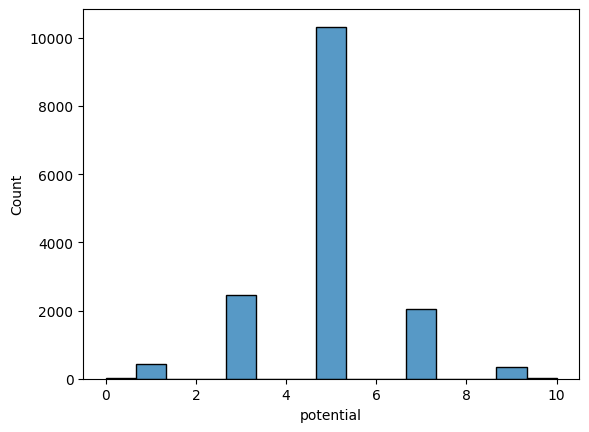

In [51]:
std, mean = np.std(fifa_data["potential"]), np.mean(fifa_data["potential"])


class PotentialScaler:

    potential_fuzzy = {
        "giga słaby": (0, mean - 3 * std),
        "słaby": (mean - 3 * std, mean - 2 * std),
        "średnio-słaby": (mean - 2 * std, mean - 1 * std),
        "średni": (mean - 1 * std, mean + 1 * std),
        "średnio-mocny":(mean + 1 * std, mean + 2 * std),
        "mocny":(mean + 2 * std, mean + 3 * std),
        "giga mocny": (mean + 3 * std, 100)
    }

    weights = {
        "giga słaby": 0,
        "słaby": 1,
        "średnio-słaby": 3,
        "średni": 5,
        "średnio-mocny": 7,
        "mocny": 9,
        "giga mocny": 10,
    }


    def __call__(self, value: float) -> int:
        for category, (low, high) in self.potential_fuzzy.items():
            if low < value <= high:
                return self.weights[category]

scaler = PotentialScaler()

sns.histplot(fifa_data[fifa_data["year"] == 16]["potential"].map(scaler))


In [52]:
import networkx as nx

graphs = {}

for idx, (year_1, year_2) in enumerate(zip(years[:-1], years[1:])):

    year_1_data = fifa_data[fifa_data["year"] == year_1]
    year_2_data = fifa_data[fifa_data["year"] == year_2]

    clubs_2 = year_2_data[["sofifa_id", "club_name"]].set_index("sofifa_id")
    clubs_1 = year_1_data[["sofifa_id", "club_name"]].set_index("sofifa_id")
    
    merged = clubs_2.join(clubs_1, how="inner", lsuffix="_last", rsuffix="_next")

    grouped = merged.reset_index().groupby(["club_name_last", "club_name_next"]).count().rename(columns={"sofifa_id": "count"}).reset_index()
    grouped = grouped[grouped.apply(lambda x: x["club_name_last"] != x["club_name_next"], axis=1)]
    graphs[idx] = nx.from_pandas_edgelist(df=grouped, source="club_name_last", target="club_name_next", edge_attr="count", create_using=nx.DiGraph())


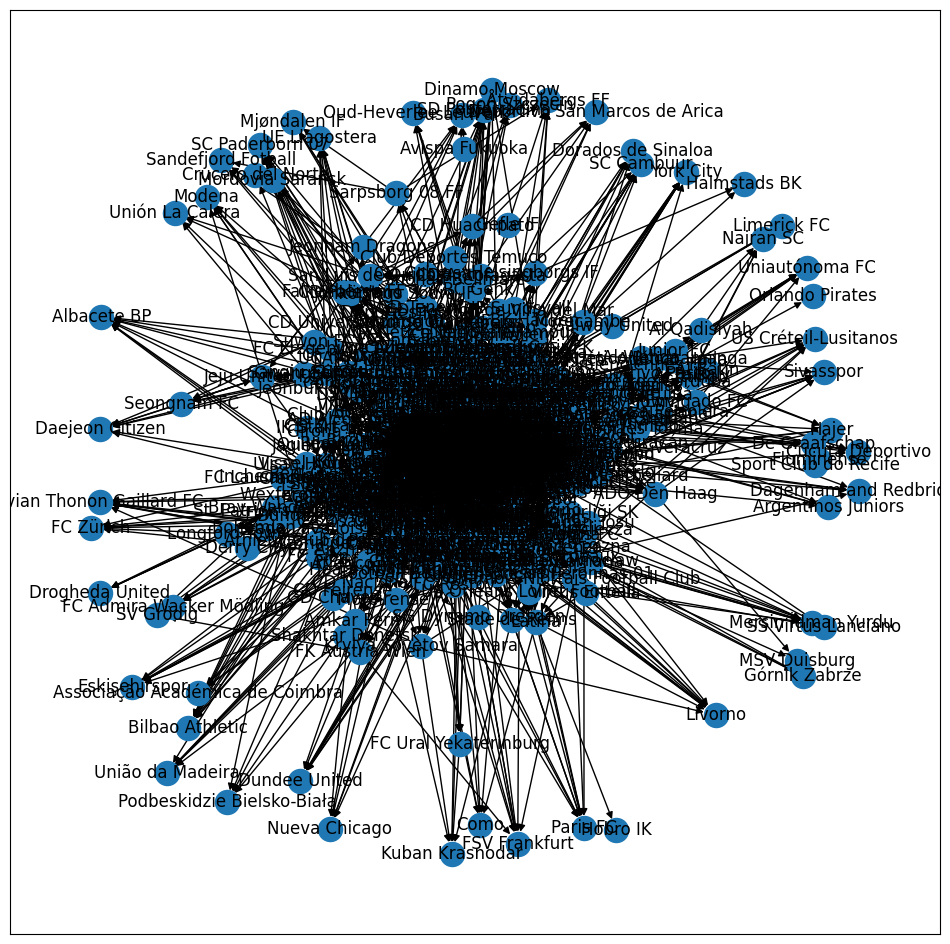

In [53]:
plt.figure(figsize=(12,12))
nx.draw_networkx(graphs[1], with_labels=True)


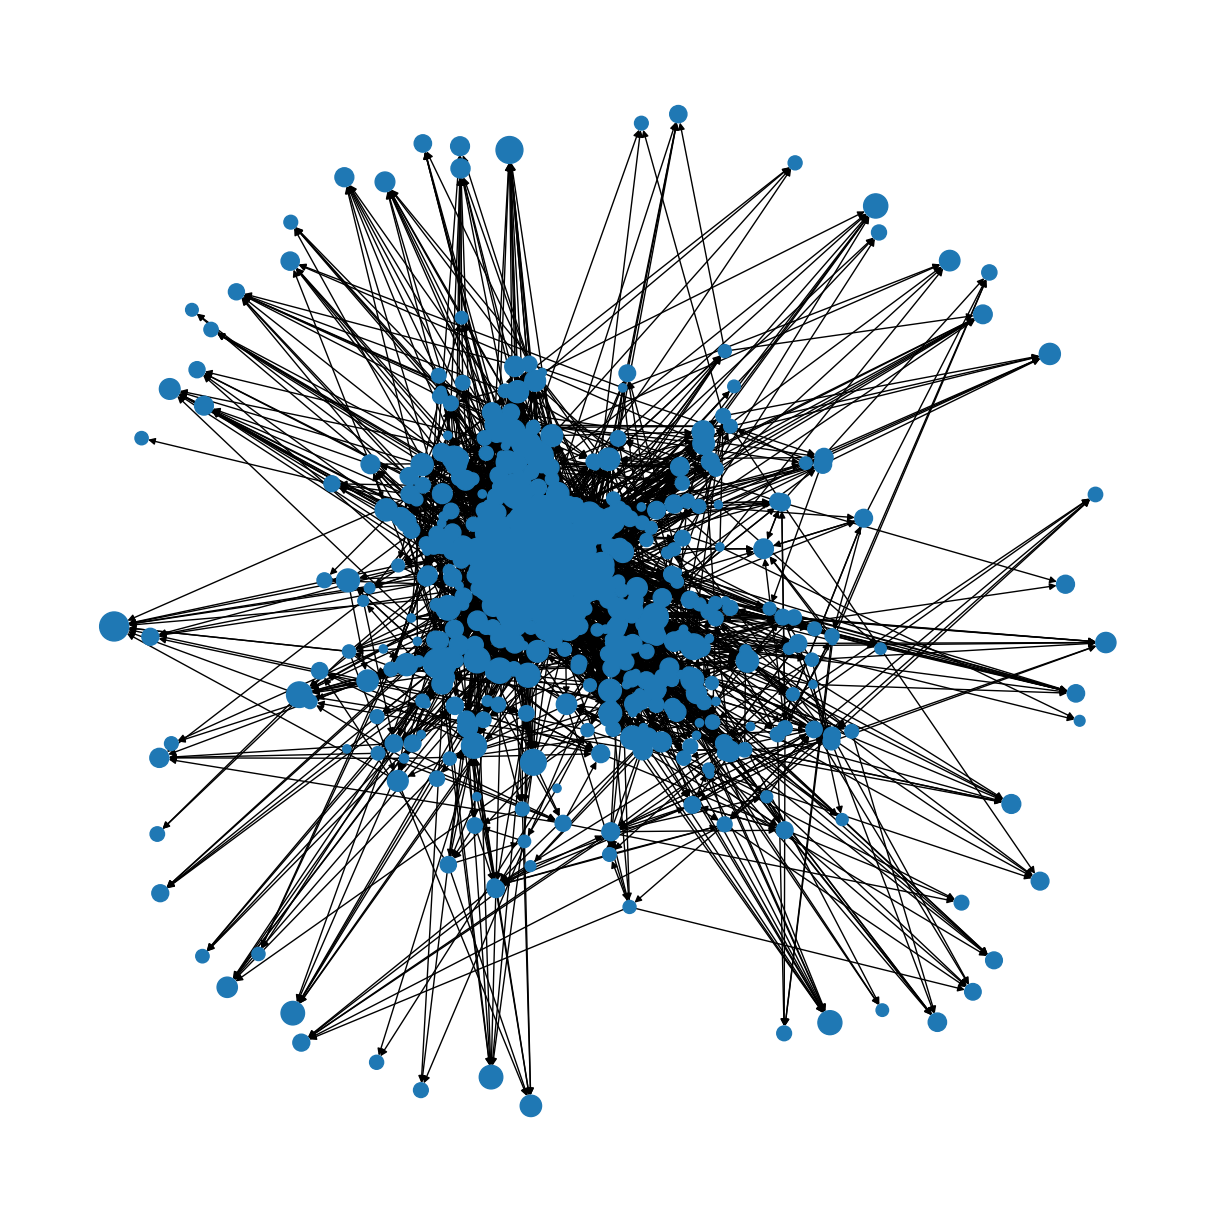

In [73]:
plt.figure(figsize=(12,12))
nx.draw(graphs[0], node_size=[rank * 100000 for rank in nx.pagerank(graphs[0]).values()], with_labels=False)
# nx.draw_circular(graphs[0])

In [55]:
groups = list(nx.community.k_clique_communities(graphs[0].to_undirected(), k=3))

colors = ['#000000', '#800000', '#008000', '#808000', '#000080', '#800080', '#008080', '#c0c0c0', '#808080', '#ff0000', '#00ff00', '#ffff00', '#0000ff', '#ff00ff', '#00ffff', '#ffffff', '#000000', '#000033', '#000066', '#000099', '#0000cc', '#0000ff', '#003300', '#003333', '#003366', '#003399', '#0033cc', '#0033ff', '#006600', '#006633', '#006666', '#006699', '#0066cc', '#0066ff', '#009900', '#009933', '#009966', '#009999', '#0099cc', '#0099ff', '#00cc00', '#00cc33', '#00cc66', '#00cc99', '#00cccc', '#00ccff', '#00ff00', '#00ff33', '#00ff66', '#00ff99', '#00ffcc', '#00ffff', '#330000', '#330033', '#330066', '#330099', '#3300cc', '#3300ff', '#333300', '#333333', '#333366', '#333399', '#3333cc', '#3333ff', '#336600', '#336633', '#336666', '#336699', '#3366cc', '#3366ff', '#339900', '#339933']

matching = {}
for group, color in zip(groups, colors):
    for club in group:
        matching[club] = color

In [56]:
len(graphs[0].nodes)

635

In [57]:
len(matching)

564

In [58]:
# nx.draw(graphs[0], color=[matching[node] for node in graphs[0].nodes], with_labels=False)

In [59]:
from pyvis.network import Network
import networkx as nx

nt = Network()
nt.from_nx(graphs[0])
nt.show_buttons(filter_=['physics'])
nt.show('nx.html')

Year 15-16
Wigan Athletic --> 33
Elche CF --> 28
Granada CF --> 27
FC Porto --> 25
Genoa --> 25
Aston Villa --> 25
Sampdoria --> 25
Hellas Verona --> 24
Olympique de Marseille --> 24
Queens Park Rangers --> 24
Rotherham United --> 23
Yeovil Town --> 23
Córdoba CF --> 22
Liverpool --> 22
Palermo --> 22
Bursaspor --> 22
Blackpool --> 22
Cambridge United --> 21
Portsmouth --> 21
Fulham --> 21
Year 16-17
Granada CF --> 35
Fulham --> 30
Sampdoria --> 28
Blackburn Rovers --> 27
Reading --> 27
RCD Espanyol --> 27
Sporting CP --> 26
Newcastle United --> 26
Middlesbrough --> 26
Quilmes Atlético Club --> 26
Elche CF --> 25
Oldham Athletic --> 25
Bristol City --> 25
Boca Juniors --> 25
Huddersfield Town --> 25
Real Zaragoza --> 25
Watford --> 25
Peterborough United --> 25
VfB Stuttgart --> 24
West Ham United --> 24
Year 17-18
Granada CF --> 39
Sporting CP --> 29
Middlesbrough --> 29
Barnsley --> 29
VfL Wolfsburg --> 27
Empoli --> 27
Galatasaray SK --> 27
Swansea City --> 27
Fiorentina --> 27
Olym

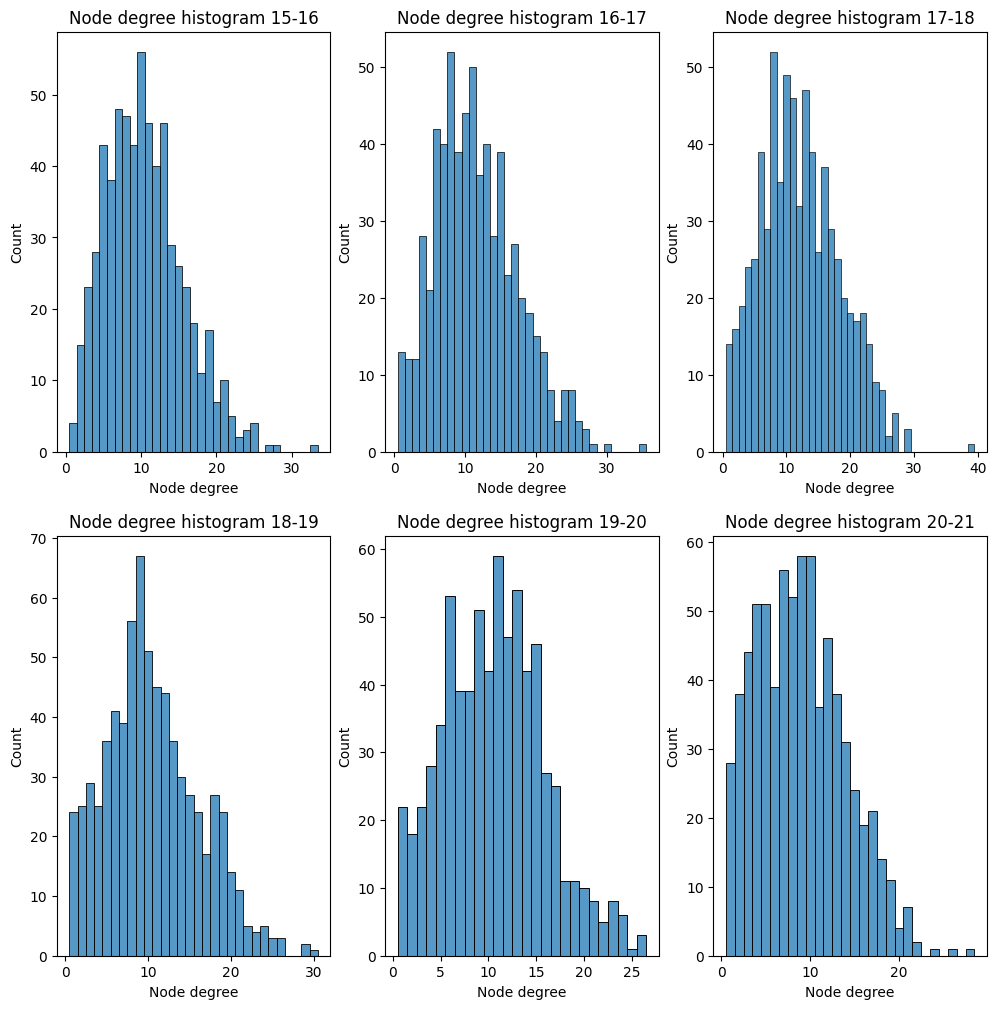

In [60]:
degree_per_year = []

fig, axs = plt.subplots(2, 3, figsize=(12,12))
axs = axs.flatten()

for idx, (graph, year) in enumerate(zip(graphs.values(), range(15, 21))):
    degree = {n: graph.degree(n) for n in graph.nodes()}
    sorted_degree = sorted(degree.items(), key= lambda item: item[1], reverse=True)
    degree_per_year.append(sorted_degree)
    sorted_degree = sorted_degree[:TOP_DISPLAY]
    print(f"Year {year}-{year+1}")
    for club, transfers in sorted_degree:
        print(f"{club} --> {transfers}")
    sns.histplot(degree, discrete=True, ax=axs[idx])
    axs[idx].set_title(f"Node degree histogram {year}-{year+1}")
    axs[idx].set_xlabel("Node degree")
    axs[idx].set_ylabel("Count")
    # plt.show()

In [61]:
team_degree_ranking = []
for year in degree_per_year:
    team_degree_ranking.append([x[0] for x in year])
best_degree_teams = [(x[0], []) for x in team_degree_ranking]

for team, arr in best_degree_teams:
    for ranking in team_degree_ranking:
        arr.append(ranking.index(team)+1)
best_degree_teams
        

[('Wigan Athletic', [1, 26, 19, 52, 3, 14]),
 ('Granada CF', [3, 1, 1, 119, 286, 89]),
 ('Granada CF', [3, 1, 1, 119, 286, 89]),
 ('Peterborough United', [364, 18, 161, 1, 153, 227]),
 ('SD Huesca', [435, 87, 276, 152, 1, 135]),
 ('Genoa', [5, 38, 21, 6, 4, 1])]

#### Co łączy kluby wykonujące najwięcej transferów?
Każdy z klubów nie jest stabilnym uczestnikiem najwyższej ligi rozgrywek w swoim regionie.

#### Czy najczęśniej dokonujące transferów kluby jednorazowo wymieniają dużą część składu, czy dzieje się to co rok?
Kluby dzielą się na dwie kategorie:
- kluby, które po wykonaniu dużej liczby transferów stabilizują swój podstawowy skład
- kluby, które z roku na rok wymieniają dużą liczbę zawodników, pełniące funkcję okresu przejściowego dla zawodników


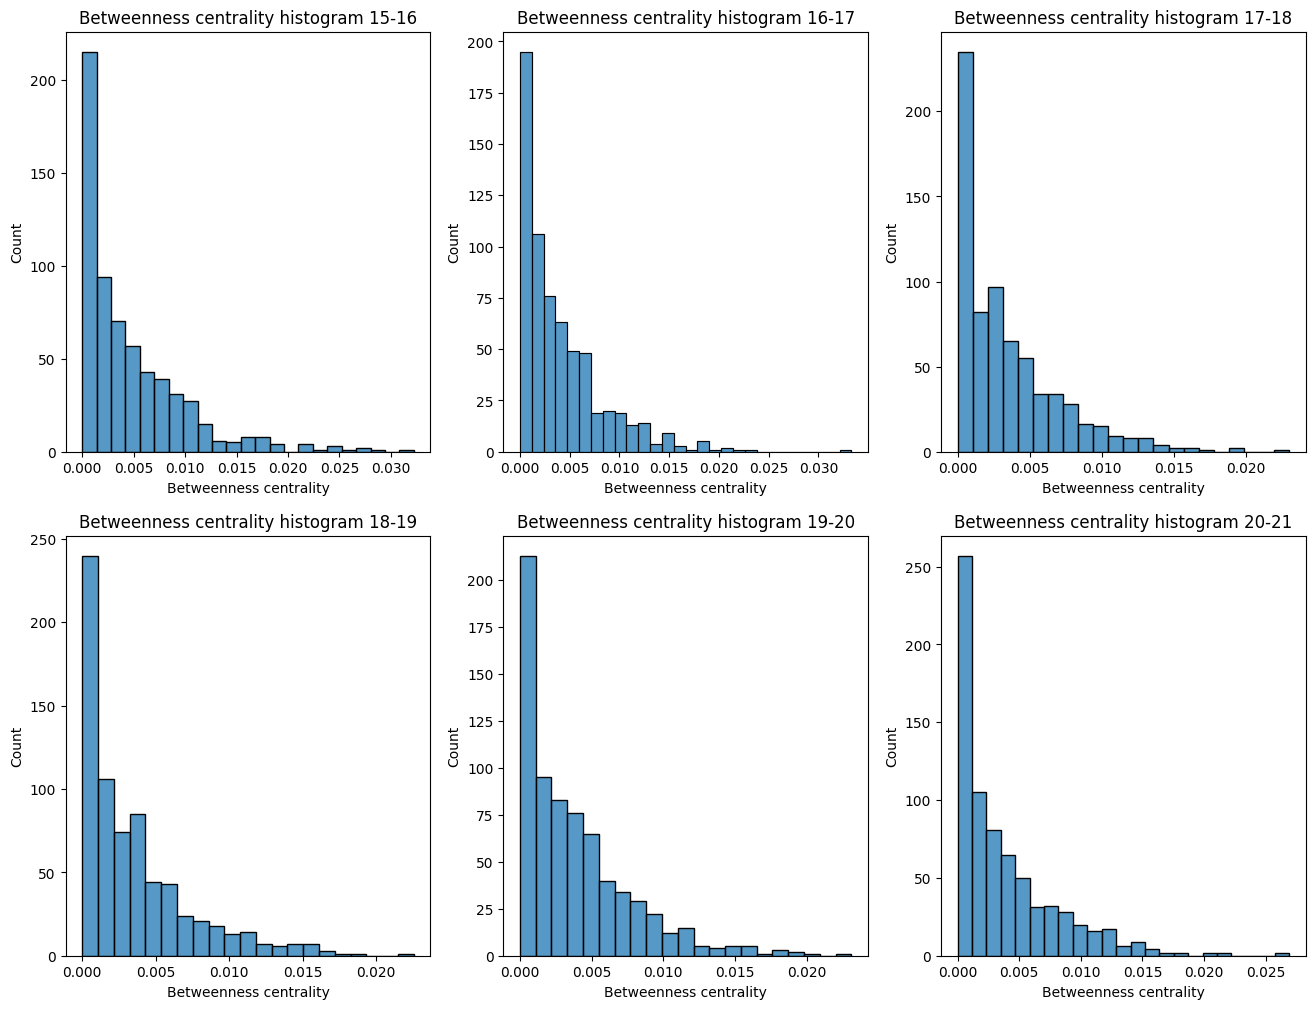

In [62]:
betweenness_per_year = []

fig, axs = plt.subplots(2, 3, figsize=(16,12))
axs = axs.flatten()

for idx, (graph, year) in enumerate(zip(graphs.values(), range(15, 21))):
    betweenness_centrality = nx.betweenness_centrality(graph)
    betweenness_sorted = sorted(betweenness_centrality.items(), key= lambda item: item[1], reverse=True)
    betweenness_per_year.append(betweenness_sorted)
    betweenness_sorted = betweenness_sorted[:TOP_DISPLAY]
    # print(f"Year {year}-{year+1}")
    # for club, transfers in betweenness_sorted:
    #     print(f"{club} --> {round(transfers, 5)}")
    ax = sns.histplot(betweenness_centrality, ax=axs[idx])
    axs[idx].set_title(f"Betweenness centrality histogram {year}-{year+1}")
    axs[idx].set_xlabel("Betweenness centrality")
    axs[idx].set_ylabel("Count")

In [63]:
team_betweenness_ranking = []
for year in betweenness_per_year:
    team_betweenness_ranking.append([x[0] for x in year])
best_betweenness_teams = [(x[0], []) for x in team_betweenness_ranking]

for team, arr in best_betweenness_teams:
    for ranking in team_betweenness_ranking:
        arr.append(ranking.index(team)+1)
best_betweenness_teams

[('Wigan Athletic', [1, 37, 171, 108, 38, 152]),
 ('Boca Juniors', [140, 1, 61, 119, 7, 90]),
 ('Granada CF', [12, 5, 1, 102, 225, 119]),
 ('Deportivo de La Coruña', [65, 68, 255, 1, 59, 573]),
 ('Genoa', [25, 59, 58, 6, 1, 1]),
 ('Genoa', [25, 59, 58, 6, 1, 1])]

#### Który z klubów pełnił kluczową rolę w przepływie transferów między klubami?
Genoa

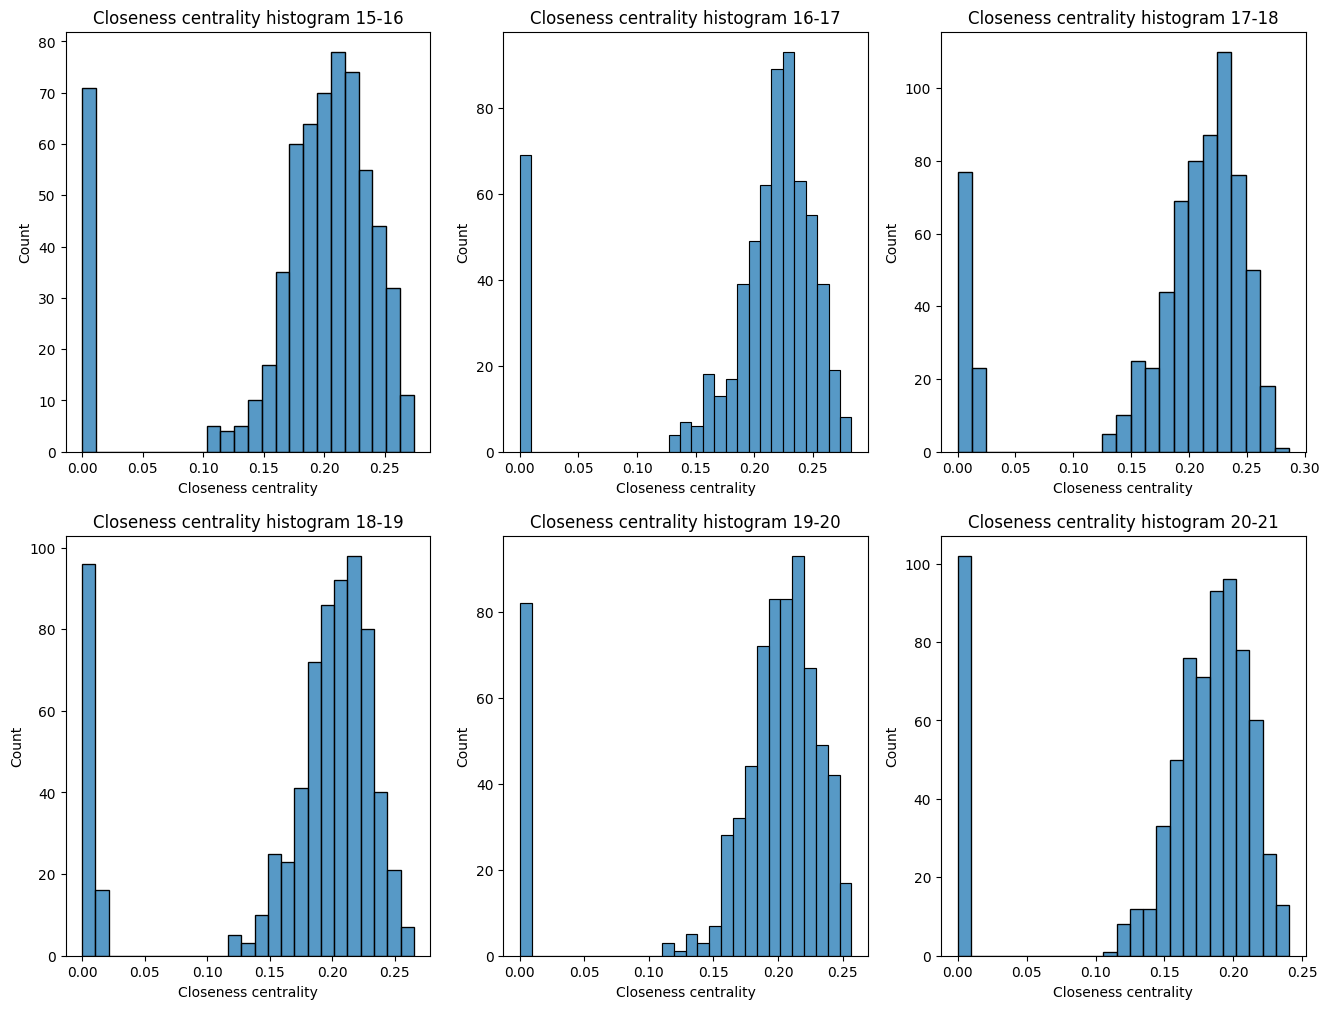

In [64]:
closeness_per_year = []

fig, axs = plt.subplots(2, 3, figsize=(16,12))
axs = axs.flatten()

for idx, (graph, year) in enumerate(zip(graphs.values(), range(15, 21))):
    closeness_centrality = nx.closeness_centrality(graph)
    closeness_sorted = sorted(closeness_centrality.items(), key= lambda item: item[1], reverse=True)
    closeness_per_year.append(closeness_sorted)
    closeness_sorted = closeness_sorted[:TOP_DISPLAY]
    # print(f"Year {year}-{year+1}")
    # for club, transfers in closeness_sorted:
    #     print(f"{club} --> {round(transfers, 5)}")
    sns.histplot(closeness_centrality, ax=axs[idx])
    axs[idx].set_title(f"Closeness centrality histogram {year}-{year+1}")
    axs[idx].set_xlabel("Closeness centrality")
    axs[idx].set_ylabel("Count")

In [65]:
team_closeness_ranking = []
for year in closeness_per_year:
    team_closeness_ranking.append([x[0] for x in year])
best_closeness_teams = [(x[0], []) for x in team_closeness_ranking]

for team, arr in best_closeness_teams:
    for ranking in team_closeness_ranking:
        arr.append(ranking.index(team)+1)
best_closeness_teams

[('Wigan Athletic', [1, 101, 189, 134, 34, 7]),
 ('Sunderland', [126, 1, 25, 23, 43, 246]),
 ('Granada CF', [7, 10, 1, 17, 240, 152]),
 ('Deportivo de La Coruña', [83, 40, 142, 1, 134, 28]),
 ('Genoa', [10, 50, 29, 111, 1, 45]),
 ('RB Leipzig', [135, 145, 120, 68, 182, 1])]

#### Kluby mające największy wpływ na wychowanie piłkarzy?
Granada CF i Genoa

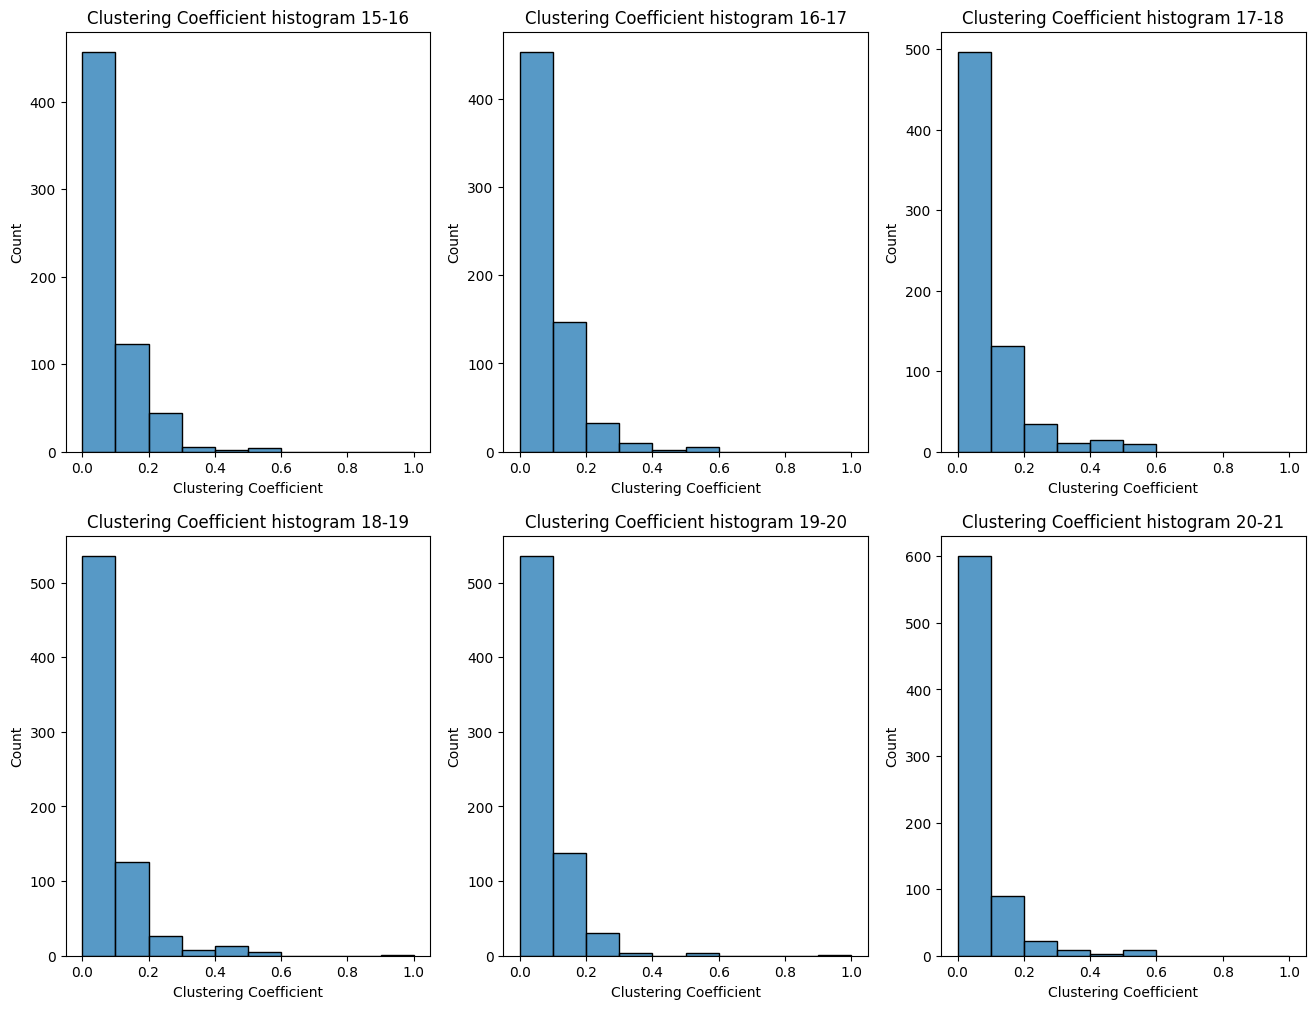

In [66]:
clustering_per_year = []

fig, axs = plt.subplots(2, 3, figsize=(16,12))
axs = axs.flatten()

for idx, (graph, year) in enumerate(zip(graphs.values(), range(15, 21))):
    clustering_coefficient = nx.clustering(graph)
    clustering_sorted = sorted(clustering_coefficient.items(), key= lambda item: item[1], reverse=True)
    clustering_per_year.append(clustering_sorted)
    clustering_sorted = clustering_sorted[:TOP_DISPLAY]
    # print(f"Year {year}-{year+1}")
    # for club, transfers in clustering_sorted:
    #     print(f"{club} --> {round(transfers, 5)}")
    
    bins = np.arange(0, 1.1, step=0.1)
    sns.histplot(list(clustering_coefficient.values()), bins=bins, ax=axs[idx])
    axs[idx].set_title(f"Clustering Coefficient histogram {year}-{year+1}")
    axs[idx].set_xlabel("Clustering Coefficient")
    axs[idx].set_ylabel("Count")

In [67]:
team_clustering_ranking = []
for year in clustering_per_year:
    team_clustering_ranking.append([x[0] for x in year])
best_clustering_teams = [(x[0], []) for x in team_clustering_ranking]

for team, arr in best_clustering_teams:
    for ranking in team_clustering_ranking:
        if team in ranking:
            arr.append(ranking.index(team)+1)
        else:
            arr.append(-1)
best_clustering_teams

[('Al Fateh', [1, 482, 167, 42, 136, 65]),
 ('Adanaspor', [-1, 1, 683, -1, -1, -1]),
 ('Vasco da Gama', [-1, -1, 1, -1, -1, -1]),
 ('Gyeongnam FC', [365, -1, -1, 1, 40, 20]),
 ('Vendsyssel FF', [-1, -1, -1, 714, 1, -1]),
 ('Patriotas Boyacá FC', [11, 56, 102, 54, 90, 1])]

#### W których krajach utworzyły się grupy klubów najczęściej wymieniających się piłkarzami?
- Południowa Korea
- Dania
- Brazylia
- Turcja
- Kolumnia
- Arabia Saudyjska

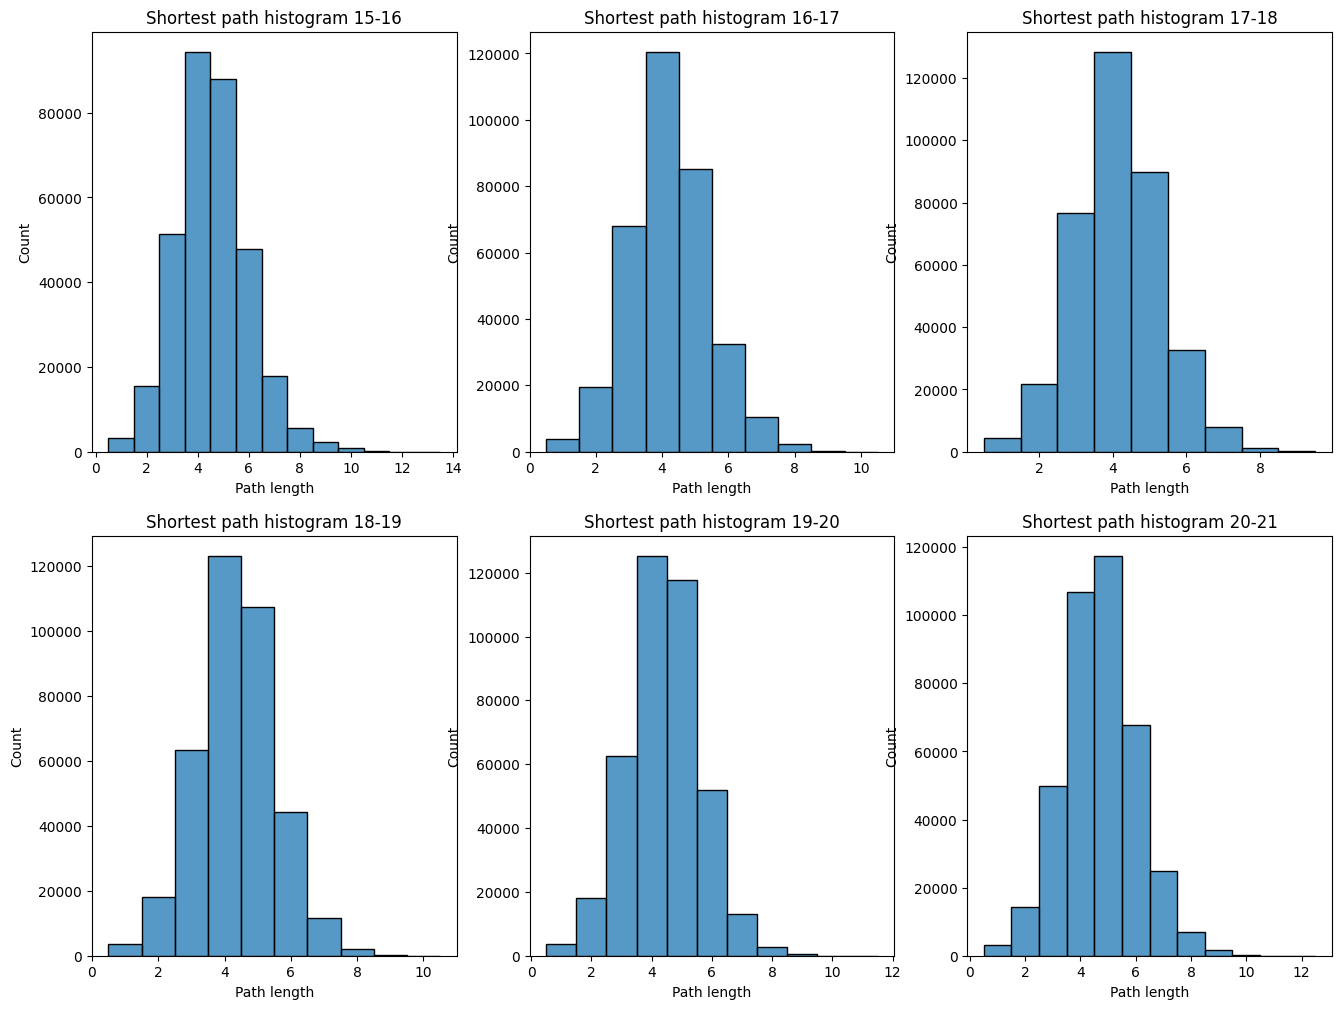

In [68]:
longest_shortest_paths = []

fig, axs = plt.subplots(2, 3, figsize=(16,12))
axs = axs.flatten()

for idx, (graph, year) in enumerate(zip(graphs.values(), range(15, 21))):
    shortest_paths = list(nx.shortest_path_length(graph))
    lengths = []
    for node1, connections in shortest_paths:
        for node2, length in connections.items():
            if node1 == node2:
                continue
        
            lengths.append(length)

    longest_shortest_paths.append(np.max(lengths))

    ax = sns.histplot(lengths, discrete=True, ax=axs[idx])
    axs[idx].set_title(f"Shortest path histogram {year}-{year+1}")
    axs[idx].set_xlabel("Path length")
    axs[idx].set_ylabel("Count")

In [69]:
longest_shortest_paths

[13, 10, 9, 10, 11, 12]

#### Hipoteza sześciu stopni oddalenia w transferowym świecie piłki nożnej
W różnych latach wartość zmienia się, oscylując między 9-13. Jednak znajomości są liczone tylko w roku danego transferu.

In [70]:
import random

all_nodes = set()
all_edges = set()
for graph in graphs.values():
    nodes = set(graph.nodes())
    all_nodes = all_nodes | nodes
    edges = set(graph.edges())
    all_edges = all_edges | edges

full_graph = nx.DiGraph()
full_graph.add_nodes_from(all_nodes)
full_graph.add_edges_from(all_edges)

In [71]:
carrier_path = ['Śląsk Wrocław']
carrier_length = 20

for _ in range(carrier_length):
    reachable_clubs = list(graph.successors(carrier_path[-1]))
    if len(reachable_clubs) == 0:
        carrier_path.append("KONTUZJA!")
        break
    carrier_path.append(random.choice(reachable_clubs))

print(carrier_path)

['Śląsk Wrocław', 'Milan', 'Crotone', 'Bristol City', 'Derby County', 'DC United', 'Monarcas Morelia', 'KONTUZJA!']


In [72]:
fifa_data["potential"] = fifa_data["potential"].map(scaler)

import networkx as nx

graphs = {}

for idx, (year_1, year_2) in enumerate(zip(years[:-1], years[1:])):

    year_1_data = fifa_data[fifa_data["year"] == year_1]
    year_2_data = fifa_data[fifa_data["year"] == year_2]

    clubs_2 = year_2_data[["sofifa_id", "club_name", "potential"]].set_index("sofifa_id")
    clubs_1 = year_1_data[["sofifa_id", "club_name", "potential"]].set_index("sofifa_id")
    
    merged = clubs_2.join(clubs_1, how="inner", lsuffix="_last", rsuffix="_next")

    grouped = merged.reset_index().groupby(["club_name_last", "club_name_next"]).count().rename(columns={"sofifa_id": "count"}).reset_index()
    grouped = grouped[grouped.apply(lambda x: x["club_name_last"] != x["club_name_next"], axis=1)]
    graphs[idx] = nx.from_pandas_edgelist(df=grouped, source="club_name_last", target="club_name_next", edge_attr="count", create_using=nx.DiGraph())
